In [283]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import scipy.stats as stats

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\elmog\AppData\Local\Temp\ipykernel_10604\2469573821.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [284]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [285]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 

# print(f'data: {heart_disease.data}')
# print(f'metadata: {heart_disease.metadata}')
# print(f'var: {heart_disease.variables}')

In [286]:
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

y = (y['num'] >  0).astype(int)
# print(y)
# print(y.values)
# print(y.keys())

print(f'features keys:\n{X.keys()}')
# print('###############################')
# print('###############################')
# print('###############################')
# print(f'Targets num:\n{y}')
# we need to group them "binarize" into 0 & (1,2,3)=1


features keys:
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')


In [287]:
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0


In [288]:
# drop the rows that contain ?
X = X.replace('?', np.nan)
rows_with_nan = X[X.isna().any(axis=1)]
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0


In [289]:
X = X.dropna()
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0


In [290]:
y = y.drop(rows_with_nan.index)
y

0      0
1      1
2      1
3      0
4      0
      ..
297    1
298    1
299    1
300    1
301    1
Name: num, Length: 297, dtype: int32

In [291]:
X.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


In [292]:
X.shape[1]

13

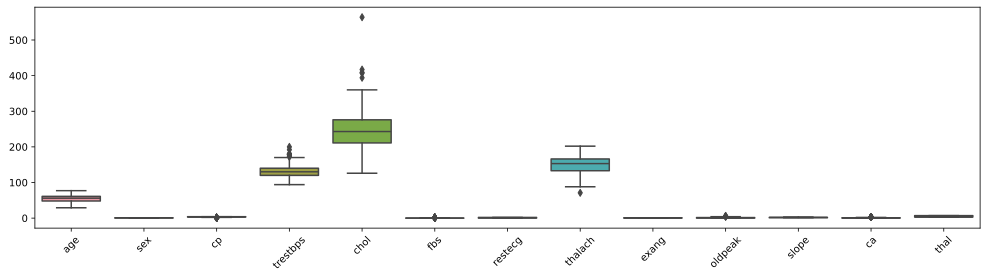

In [293]:
# check the distributions to decide on dropping and outliers & normalizations
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=X)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [294]:
# Step 0: Normalize data
# z-score all inputs features
cols2zscore = X.keys()
cols2zscore = cols2zscore.drop(['sex','fbs','exang'])
cols2zscore

# method 1 for z-score
X[cols2zscore] = X[cols2zscore].apply(stats.zscore)

# method 2 for z-score
# for c in cols2zscore:
#     d = pd.to_numeric(X[c]) #force to numeric (addresses some data-format issues)
#     X[c] = (d - d.mean()) / d.std(ddof=1)

C:\Users\elmog\AppData\Local\Temp\ipykernel_10604\560886200.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cols2zscore] = X[cols2zscore].apply(stats.zscore)


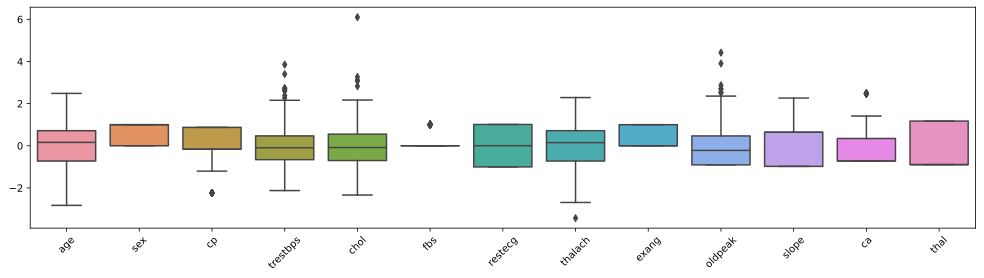

In [295]:
# check the distributions again
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=X)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [296]:
# Step1: Convert numpy data into tensor data
xx = torch.tensor( X.values ).float()
yy  = torch.tensor( y.values  ).float()

In [297]:
xx.shape

torch.Size([297, 13])

In [298]:
yy = yy[:,None]
yy.shape # if it is [num-only] -> notmatrix
# convert it to a matrix
# labels = labels[:,None] 
# yy

torch.Size([297, 1])

In [299]:
# Step2: use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(xx, yy, test_size=0.1)

In [300]:
# Step 3: Convert into PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data  = TensorDataset(test_data , test_labels)

In [301]:
train_data.tensors[0].shape

torch.Size([267, 13])

In [302]:
test_data.tensors[0].shape

torch.Size([30, 13])

In [303]:
# Step 4: Translate into dataloader objects
batchsize    = 8
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_data,  batch_size=test_data.tensors[0].shape[0])

In [304]:
# Create the Deep Learning Model
def createTheNet():
    class diseasePredictionNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(13,26)
            
            # self.bnormHidden1 =  nn.BatchNorm1d(26)
            self.hidden1 = nn.Linear(26,26)
            
            # self.bnormHidden2 =  nn.BatchNorm1d(26)
            self.hidden2 = nn.Linear(26,13)
            
            self.output = nn.Linear(13,1)
            
        def forward(self, x):
            
            x = F.leaky_relu( self.input(x) )
            
            # x = self.bnormHidden1(x)
            x = F.leaky_relu( self.hidden1(x) )

            # x = self.bnormHidden2(x)
            x = F.leaky_relu( self.hidden2(x) )
            
            x = self.output(x)
            
            return x
        
    diseasePredictionModel = diseasePredictionNet().to(device)
    
    lossfun = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.Adam(diseasePredictionModel.parameters(), lr=0.01)#, betas=(0.9, 0.999), eps=1e-8)
    
    return diseasePredictionModel, lossfun, optimizer

In [305]:
# test the model that is has NO ERRORS!

net2, lossfun, optimizer = createTheNet()

input = torch.rand(26,13).to(device)
net2.eval()
net2(input)
net2.train()

diseasePredictionNet(
  (input): Linear(in_features=13, out_features=26, bias=True)
  (bnormHidden1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden1): Linear(in_features=26, out_features=26, bias=True)
  (bnormHidden2): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden2): Linear(in_features=26, out_features=13, bias=True)
  (output): Linear(in_features=13, out_features=1, bias=True)
)

In [327]:
# Train the Model

def trainTheModel(diseasePredictionTrain, lossfun, optimizer, epochs=100):
    
    #number of epochs to train
    numepochs = epochs
        
    #initialize losses & accuracy
    losses   = torch.zeros(numepochs)
    trainAcc = []
    testAcc  = []
    
    for epochi in range(numepochs):
        
        #batch loss & accuracy
        batchLoss = []
        batchAcc  = []
        
        #loop over mini-batches
        for X,y in train_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)
            
            #Forward pass & loss
            yHat = diseasePredictionTrain(X)
            loss = lossfun(yHat, y)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #loss from this batch
            batchLoss.append(loss.item())
            
            # accuracy from this batch for categorical data
            # batchMathces = (torch.abs(yHat - y)).detach().cpu().float().numpy()
            # batchAcc.append(( batchMathces < 1))
            
            #accuracy from this batch -> for BCE
            accMatches = torch.argmax(yHat,axis=1) == y ##
            accMatchesNumeric = accMatches.float()
            batchAcc.append( 100*torch.mean(accMatchesNumeric).item() )
        
        #average accuracy across mini-batches
        trainAcc.append(100 * np.mean((batchAcc)))
        
        #average losses across all mini-batches
        losses[epochi] = np.mean(batchLoss)
        
        ################################
        
        #final forward pass for Test Accuracy
        X,y = next(iter(test_loader))
        
        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            yHat = diseasePredictionTrain(X)
            
        #compute the test accuracy for categorical data
        # testMatches = (torch.abs(yHat - y)).detach().cpu().float().numpy()
        # testMatchesNumeric = (testMatches < 1)
        # testAcc.append(100 * np.mean( testMatchesNumeric ) )

        #compute the test accuracy for BCE
        testMatches = torch.argmax(yHat, axis=1) == y
        testMatchesNumeric = testMatches.float()
        testAcc.append(100 * torch.mean( testMatchesNumeric ).item() )
    
    return trainAcc, testAcc, losses, diseasePredictionTrain

In [328]:
# Test the training code that it has NO ERRORS
epochs=1
diseaseModel, lossfun, optimizer = createTheNet()
trainAcc, testAcc, losses, diseasePredictionTrained = trainTheModel(diseaseModel, lossfun, optimizer, epochs)

In [329]:
# Train the Model
diseaseModel, lossfun, optimizer = createTheNet()
trainAcc, testAcc, losses, diseasePredictionTrained = trainTheModel(diseaseModel, lossfun, optimizer)

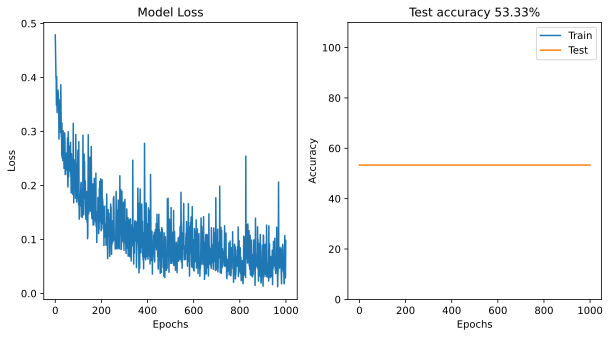

In [330]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Test accuracy {testAcc[-1]:.2f}%')
ax[1].set_ylim([0,110])

plt.show()